In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyspark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when,mean,count, col,desc,year, quarter, when,lit, to_date, to_timestamp, concat, avg,countDistinct
from pyspark.sql.types import StringType
from pyspark.sql.functions import regexp_replace
from pyspark.ml.feature import StringIndexer
import pandas as pd
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 20.4 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=df28ba3a1835cfeb0cec69212954a9eb73a0d7b9d209b019d8793e2031ec45f8
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [3]:
spark = SparkSession.builder.appName("Attrition_Prediction").getOrCreate()

In [4]:
df = spark.read.csv("/content/drive/MyDrive/Project_Data/WA_Fn-UseC_-HR-Employee-Attrition.csv",inferSchema=True, header=True)

In [5]:
df.count()

1470

In [6]:
df.show(5)

+---+---------+-----------------+---------+--------------------+----------------+---------+--------------+-------------+--------------+-----------------------+------+----------+--------------+--------+--------------------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
|Age|Attrition|   BusinessTravel|DailyRate|          Department|DistanceFromHome|Education|EducationField|EmployeeCount|EmployeeNumber|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|             JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|Over18|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalanc

In [7]:
df.select("Attrition").show(5)

+---------+
|Attrition|
+---------+
|      Yes|
|       No|
|      Yes|
|       No|
|       No|
+---------+
only showing top 5 rows



In [8]:
df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeCount: integer (nullable = true)
 |-- EmployeeNumber: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- MonthlyRate: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- Over18: string (nullable = true)
 |-- OverTime: string 

by this we get to know which are categorical and which are numerical columns in our dataset

our target variable is "Attrition"

In [9]:
df.groupBy("Attrition").count().show()

+---------+-----+
|Attrition|count|
+---------+-----+
|       No| 1233|
|      Yes|  237|
+---------+-----+



In [10]:
df.groupBy("Gender").count().show()

+------+-----+
|Gender|count|
+------+-----+
|Female|  588|
|  Male|  882|
+------+-----+



In [11]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

to convert categorical variables in numeric we can write the function as follows

In [12]:
cat_columns = ["Attrition","BusinessTravel","Department","EducationField","Gender","JobRole","MaritalStatus","Over18","OverTime"]

def categorical_to_numeric(df, cat_columns):
    for col in cat_columns:
        indexer = StringIndexer(inputCol=col, outputCol=col+"_Num")
        df = indexer.fit(df).transform(df)
        df = df.drop(col)
    return df
df = categorical_to_numeric(df, cat_columns)
df.show(5)

+---+---------+----------------+---------+-------------+--------------+-----------------------+----------+--------------+--------+---------------+-------------+-----------+------------------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+-------------+------------------+--------------+------------------+----------+-----------+-----------------+----------+------------+
|Age|DailyRate|DistanceFromHome|Education|EmployeeCount|EmployeeNumber|EnvironmentSatisfaction|HourlyRate|JobInvolvement|JobLevel|JobSatisfaction|MonthlyIncome|MonthlyRate|NumCompaniesWorked|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalance|YearsAtCompany|YearsInCurrentRole|YearsSinceLastPromotion|YearsWithCurrManager|Attrition_Num|BusinessTravel_Nu

In [13]:
#indexer = StringIndexer(inputCol="Attrition",outputCol="Attrition_Num")
#indexed = indexer.fit(df).transform(df)
#indexer = StringIndexer(inputCol="BusinessTravel",outputCol="BusinessTravel_Num")
#indexed = indexer.fit(indexed).transform(indexed)
#indexer = StringIndexer(inputCol="Department",outputCol="Department_Num")
#indexed = indexer.fit(indexed).transform(indexed)
#indexer = StringIndexer(inputCol="EducationField",outputCol="EducationField_Num")
#indexed = indexer.fit(indexed).transform(indexed)
#indexer = StringIndexer(inputCol="Gender",outputCol="Gender_Num")
#indexed = indexer.fit(indexed).transform(indexed)
#indexer = StringIndexer(inputCol="JobRole",outputCol="JobRole_Num")
#indexed = indexer.fit(indexed).transform(indexed)
#indexer = StringIndexer(inputCol="MaritalStatus",outputCol="MaritalStatus_Num")
#indexed = indexer.fit(indexed).transform(indexed)
#indexer = StringIndexer(inputCol="Over18",outputCol="Over18_Num")
#indexed = indexer.fit(indexed).transform(indexed)
#indexer = StringIndexer(inputCol="OverTime",outputCol="OverTime_Num")
#indexed = indexer.fit(indexed).transform(indexed) 

# EDA and **Visualization**

In [14]:
df1= df.toPandas()
import seaborn as sns
import matplotlib.pyplot as plt

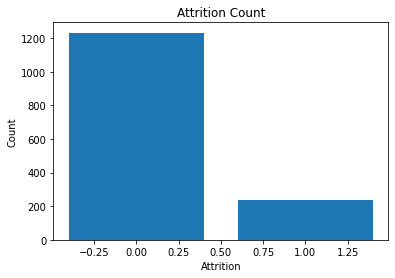

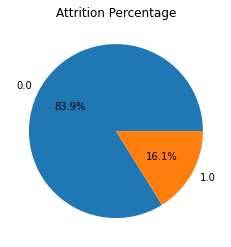

In [15]:
# Count the number of values for each category
attrition_counts = df1["Attrition_Num"].value_counts()

# Plot a bar chart
plt.bar(attrition_counts.index, attrition_counts.values)
plt.xlabel("Attrition")
plt.ylabel("Count")
plt.title("Attrition Count")
plt.show()

# Plot a pie chart
plt.pie(attrition_counts.values, labels=attrition_counts.index, autopct='%1.1f%%')
plt.title("Attrition Percentage")
plt.show()

# Uni Variate numerical Feature Analysis


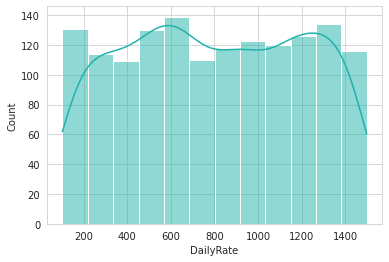

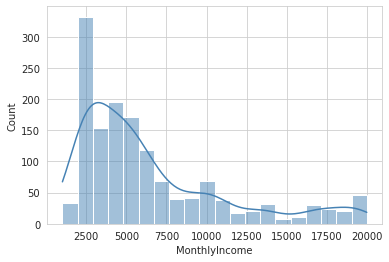

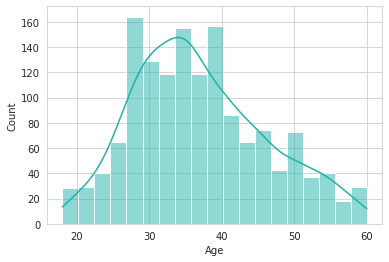

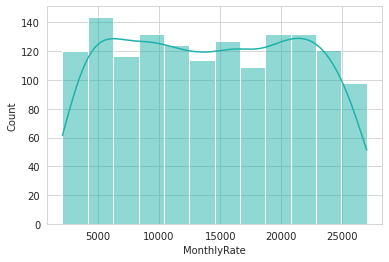

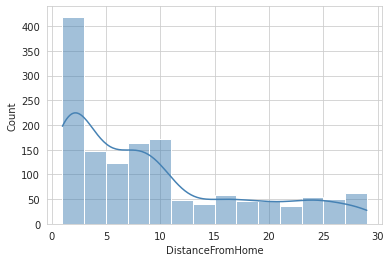

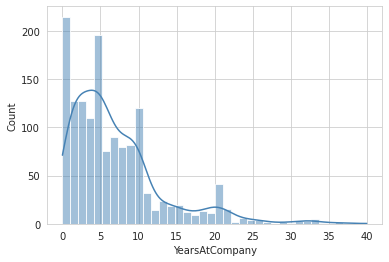

<Figure size 432x288 with 0 Axes>

In [16]:
sns.set_style('whitegrid')
sns.histplot(data=df1, x='DailyRate', kde=True, color='lightseagreen'); plt.show()
sns.histplot(data=df1, x='MonthlyIncome', kde=True, color='steelblue'); plt.show()
sns.histplot(data=df1, x='Age', kde=True, color='lightseagreen'); plt.show()
sns.histplot(data=df1, x='MonthlyRate', kde=True, color='lightseagreen');plt.show()
sns.histplot(data=df1, x='DistanceFromHome', kde=True, color='steelblue');plt.show()
sns.histplot(data=df1, x='YearsAtCompany', kde=True, color='steelblue'); plt.show()
sns.despine(left=True)


Above plot shows that MonthlyIncome, DistanceFromHome, YearsAtCompany features have outliers

#  Bi Variate Catagorical Feature Analysis

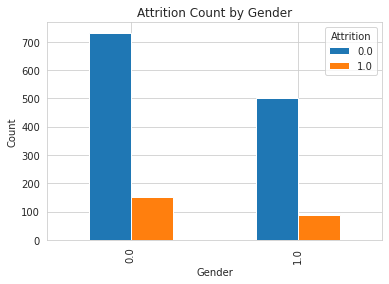

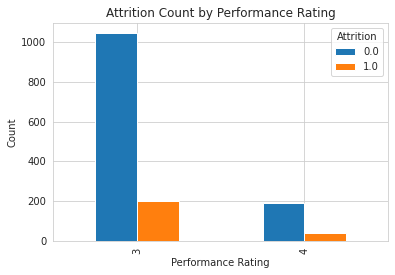

In [17]:
# Count the number of values for each category
attrition_counts = df1.groupby("Gender_Num")["Attrition_Num"].value_counts().unstack()

# Plot a bar chart
attrition_counts.plot(kind="bar")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Attrition Count by Gender")
plt.legend(title="Attrition", loc="upper right")
plt.show()

# Count the number of values for each category
attrition_counts = df1.groupby("PerformanceRating")["Attrition_Num"].value_counts().unstack()
 
# Plot a bar chart
attrition_counts.plot(kind="bar")
plt.xlabel("Performance Rating")
plt.ylabel("Count")
plt.title("Attrition Count by Performance Rating")
plt.legend(title="Attrition", loc="upper right")
plt.show()

**Above analysis shows that**

Attrition rate for male(0.0) and female(1.0) in Gender feature is almost equal.

Attrition rate for 3 and 4 in PerformanceRating is almost equal.

they have negligible influence of target variable, and we can drop them

# Multi Variate Feature Analysis

<Axes: xlabel='Gender_Num', ylabel='MonthlyIncome'>

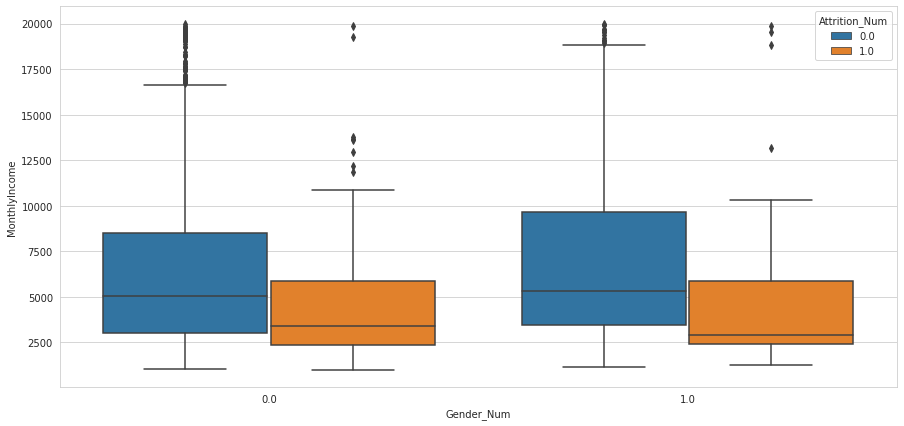

In [18]:
plt.figure(figsize=(15,7))
sns.boxplot(x="Gender_Num", y="MonthlyIncome", data=df1,hue='Attrition_Num')

<Axes: xlabel='Gender_Num', ylabel='Age'>

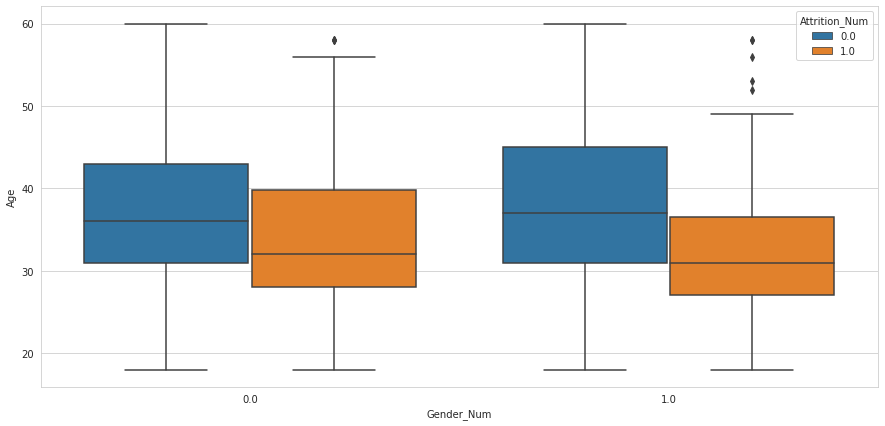

In [19]:
plt.figure(figsize=(15,7))
sns.boxplot(x="Gender_Num", y="Age", data=df1,hue='Attrition_Num')

In [20]:
print("male : 0.0 , Female : 1.0")
print("Attrition, 'Yes': 1.0 , 'No' : 0.0 ")
print(df1.groupby('Gender_Num')['Attrition_Num'].mean().to_frame());
print(df1.groupby(['Gender_Num','Attrition_Num'])['MonthlyIncome'].mean().to_frame())
df1.groupby(['Gender_Num','Attrition_Num'])['MonthlyIncome'].median().to_frame()

male : 0.0 , Female : 1.0
Attrition, 'Yes': 1.0 , 'No' : 0.0 
            Attrition_Num
Gender_Num               
0.0              0.170068
1.0              0.147959
                          MonthlyIncome
Gender_Num Attrition_Num               
0.0        0.0              6704.964481
           1.0              4797.160000
1.0        0.0              7019.429142
           1.0              4769.735632


MonthlyIncome
Gender_Num Attrition_Num               
0.0        0.0                   5075.0
           1.0                   3407.5
1.0        0.0                   5329.0
           1.0                   2886.0

Above analysis confirms that Attrition rate of male is a slightly higher than female and can be neglected.

MonthlyIncome rate, Age is almost equal for both Gender.

Therefore, we can conclude that Gender does not have much influence for Employee Attrition.

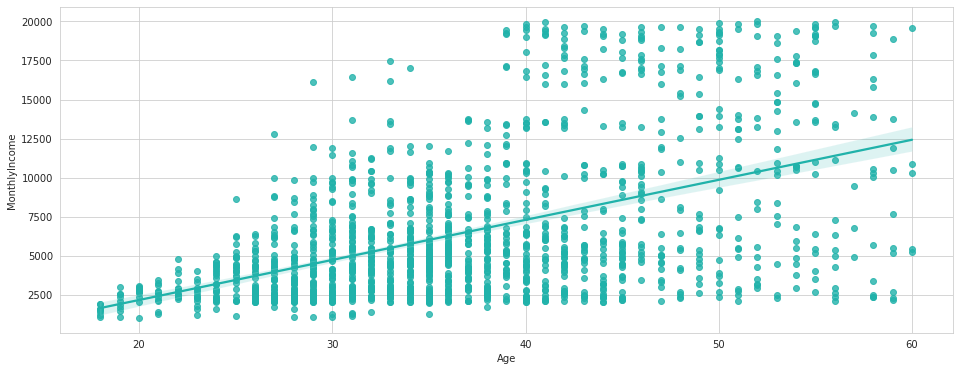

There is a linear relation between Age and Monthly income


In [21]:
#Plotting Age vs monthly income
plt.figure(figsize = (16,6))
sns.regplot(x= 'Age', y = 'MonthlyIncome' , data = df1,color='lightseagreen')
plt.show()
print("There is a linear relation between Age and Monthly income")

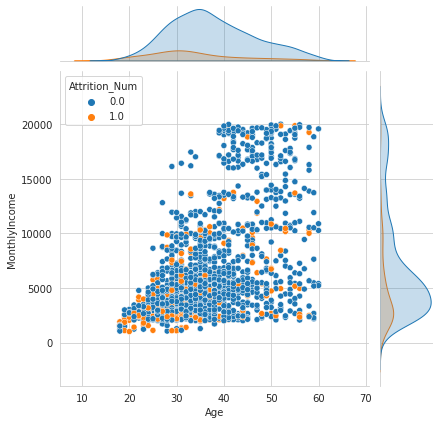

                     Age
Attrition_Num           
0.0            37.561233
1.0            33.607595
               MonthlyIncome
Attrition_Num               
0.0              6832.739659
1.0              4787.092827


In [22]:
sns.jointplot(x='Age',y='MonthlyIncome',data=df1,hue='Attrition_Num')
plt.show()
print(df1.groupby(['Attrition_Num'])['Age'].mean().to_frame())
print(df1.groupby(['Attrition_Num'])['MonthlyIncome'].mean().to_frame())

**Attrition rate is higher for those employees who are having lower income as well as younger in age.**

sales : 0.0 , Research & Development : 1.0 , Human Resources : 2.0


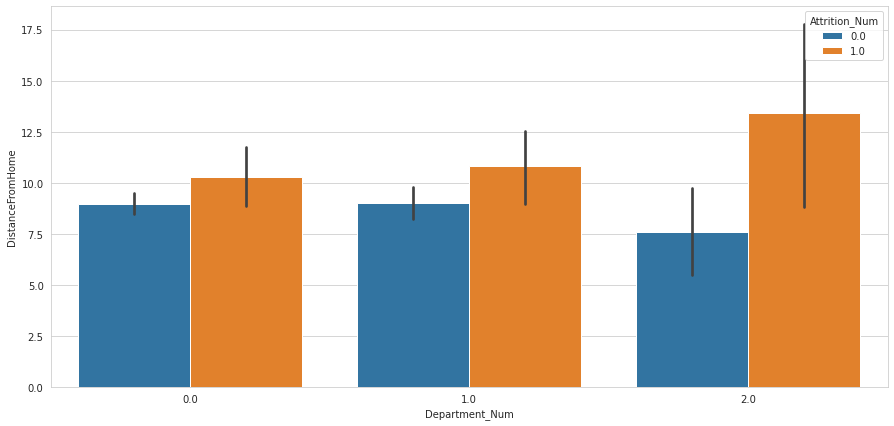

In [23]:
plt.figure(figsize=(15,7))
sns.barplot(x='Department_Num',y='DistanceFromHome',data=df1,hue='Attrition_Num')
print("sales : 0.0 , Research & Development : 1.0 , Human Resources : 2.0")

**Employee those are leaving far away from the compnay, they have more chance to leave the company.**

In [24]:
print(df1.groupby('JobLevel')['Attrition_Num'].mean().to_frame())
df1.groupby(['JobLevel','Attrition_Num'])['YearsAtCompany'].median().to_frame()

          Attrition_Num
JobLevel               
1              0.263352
2              0.097378
3              0.146789
4              0.047170
5              0.072464


YearsAtCompany
JobLevel Attrition_Num                
1        0.0                       4.0
         1.0                       2.0
2        0.0                       6.0
         1.0                       5.0
3        0.0                       9.0
         1.0                       8.5
4        0.0                      12.0
         1.0                      19.0
5        0.0                      15.0
         1.0                      24.0

**Employee working in company for 2 years as well as in JobLevel 1 group have high chance to leave the company.**

                 Attrition_Num
JobSatisfaction               
1                     0.228374
2                     0.164286
3                     0.165158
4                     0.113290
                               MonthlyIncome
JobSatisfaction Attrition_Num               
1               0.0              7096.901345
                1.0              4752.803030
2               0.0              6834.893162
                1.0              4962.760870
3               0.0              6853.311653
                1.0              4595.986301
4               0.0              6668.113022
                1.0              4943.500000


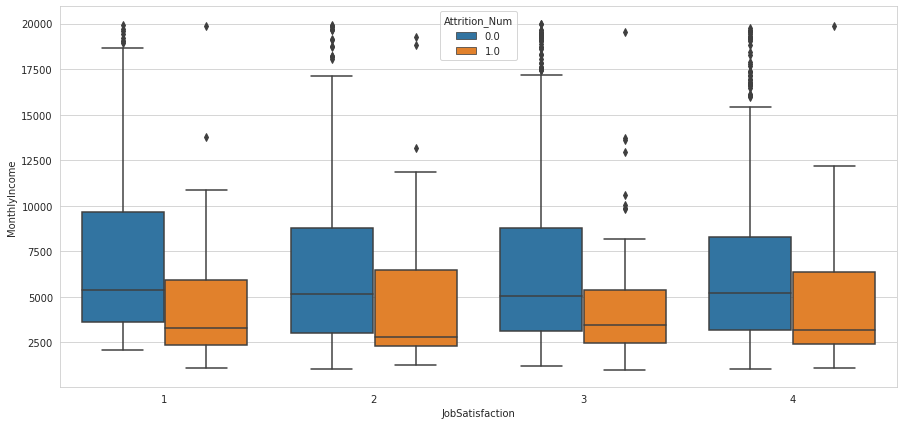

In [25]:
print(df1.groupby('JobSatisfaction')['Attrition_Num'].mean().to_frame())
print(df1.groupby(['JobSatisfaction','Attrition_Num'])['MonthlyIncome'].mean().to_frame())
plt.subplots(figsize=(15,7))
sns.boxplot(x='JobSatisfaction',y='MonthlyIncome',data=df1,hue='Attrition_Num')
plt.show()

**Employee having MonthlyIncome rate is low and JobSatisfaction level 1, have more chance to leave the company**

In [26]:
print(df1.groupby('MaritalStatus_Num')['Attrition_Num'].mean().to_frame())
print("\n 0.0 : Married , 1.0 : Single , 2.0 : Divorced")
df1.groupby(['MaritalStatus_Num','Attrition_Num'])['MonthlyIncome'].mean().to_frame()

                   Attrition_Num
MaritalStatus_Num               
0.0                     0.124814
1.0                     0.255319
2.0                     0.100917

 0.0 : Married , 1.0 : Single , 2.0 : Divorced


MonthlyIncome
MaritalStatus_Num Attrition_Num               
0.0               0.0              6969.779287
                  1.0              5558.821429
1.0               0.0              6401.600000
                  1.0              4395.766667
2.0               0.0              7071.455782
                  1.0              4245.696970

**Employee those are Single and MonthlyIncome rate is low, have high chance to leave the company**

In [27]:
# Compute the correlation coefficients between columns
corr_with_target = df1.corr()["Attrition_Num"]
corr_with_target.to_frame()

,Attrition_Num
Age,-0.159205
DailyRate,-0.056652
DistanceFromHome,0.077924
Education,-0.031373
EmployeeCount,NaN
EmployeeNumber,-0.010577
EnvironmentSatisfaction,-0.103369
HourlyRate,-0.006846
JobInvolvement,-0.130016
JobLevel,-0.169105


# lets drop un-necessary columns from our df dataframe

In [28]:
unnecessary_cols = ["EmployeeCount","Over18_Num","Gender_Num","StandardHours","EmployeeNumber","PerformanceRating"]
def drop_columns(df, unnecessary_cols):
    for col in unnecessary_cols:
        df = df.drop(col)
    return df
df = drop_columns(df,unnecessary_cols)
df.columns

['Age',
 'DailyRate',
 'DistanceFromHome',
 'Education',
 'EnvironmentSatisfaction',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobSatisfaction',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'Attrition_Num',
 'BusinessTravel_Num',
 'Department_Num',
 'EducationField_Num',
 'JobRole_Num',
 'MaritalStatus_Num',
 'OverTime_Num']

# we know our dataset is imbalanced , lets balance the dataset using "unionAll" function with parametre "Fraction" which is actually responsible for Oversampling the minority class

In [29]:
df.show()

+---+---------+----------------+---------+-----------------------+----------+--------------+--------+---------------+-------------+-----------+------------------+-----------------+------------------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+-------------+------------------+--------------+------------------+-----------+-----------------+------------+
|Age|DailyRate|DistanceFromHome|Education|EnvironmentSatisfaction|HourlyRate|JobInvolvement|JobLevel|JobSatisfaction|MonthlyIncome|MonthlyRate|NumCompaniesWorked|PercentSalaryHike|RelationshipSatisfaction|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalance|YearsAtCompany|YearsInCurrentRole|YearsSinceLastPromotion|YearsWithCurrManager|Attrition_Num|BusinessTravel_Num|Department_Num|EducationField_Num|JobRole_Num|MaritalStatus_Num|OverTime_Num|
+---+---------+----------------+---------+----------------------

In [30]:
from pyspark.sql.functions import col
# Split the DataFrame into "Yes" and "No" cases
yes_df = df.filter(col("Attrition_Num") == 1.0)
no_df = df.filter(col("Attrition_Num") == 0.0)
# Determine the number of "Yes" cases
num_yes = float(yes_df.count())
print(num_yes)
#Oversample the "Yes" cases by duplicating them
oversampled_yes_df = yes_df.unionAll(yes_df.sample(withReplacement=True,fraction= num_yes, seed=1234))
# Combine the oversampled "Yes" cases with the "No" cases
oversampled_df = oversampled_yes_df.unionAll(no_df)
print("no of rows of original dataset : ",df.count())
print("no of rows of oversampled dataset : ",oversampled_df.count())

237.0
no of rows of original dataset :  1470
no of rows of oversampled dataset :  57041


In [31]:
oversampled_df.groupBy("Attrition_Num").count().show()

+-------------+-----+
|Attrition_Num|count|
+-------------+-----+
|          1.0|55808|
|          0.0| 1233|
+-------------+-----+



Balancing Using "Agg"  and "unionAll" combining them both.

In [32]:
# Count the number of instances in each class
class_counts = df.groupBy('Attrition_Num').agg({'Attrition_Num': 'count'})

# Find the number of instances in the minority class
minority_count = class_counts.filter(col('Attrition_Num') == 1).first()['count(Attrition_Num)']
# Find the number of instances to sample from the majority class
majority_count = class_counts.filter(col('Attrition_Num') == 0).first()['count(Attrition_Num)']

undersample_ratio = minority_count / majority_count
majority_sample_count = int(majority_count * undersample_ratio)

# Sample the majority class instances
majority_df = df.filter(col('Attrition_Num') == 0).sample(False, majority_sample_count / majority_count)

# Combine the minority and majority class instances
balanced_train_df = df.filter(col('Attrition_Num') == 1).unionAll(majority_df)
balanced_train_df.groupBy("Attrition_Num").count().show()

+-------------+-----+
|Attrition_Num|count|
+-------------+-----+
|          1.0|  237|
|          0.0|  232|
+-------------+-----+



In [33]:
balanced_train_df.columns

['Age',
 'DailyRate',
 'DistanceFromHome',
 'Education',
 'EnvironmentSatisfaction',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobSatisfaction',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'Attrition_Num',
 'BusinessTravel_Num',
 'Department_Num',
 'EducationField_Num',
 'JobRole_Num',
 'MaritalStatus_Num',
 'OverTime_Num']

# now lets build a LOGISTIC REGRESSION model

In [34]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
# Define the input columns to the model
input_cols = ['Age','DailyRate','DistanceFromHome','Education','EnvironmentSatisfaction','HourlyRate','JobInvolvement','JobLevel','JobSatisfaction','MonthlyIncome','MonthlyRate','NumCompaniesWorked','PercentSalaryHike','RelationshipSatisfaction','StockOptionLevel','TotalWorkingYears','TrainingTimesLastYear','WorkLifeBalance','YearsAtCompany','YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager','BusinessTravel_Num','Department_Num','EducationField_Num','JobRole_Num','MaritalStatus_Num','OverTime_Num']
# Create a VectorAssembler object to transform input features into a single vector
assembler = VectorAssembler(inputCols=input_cols, outputCol='features')

In [35]:
# Transform the input data using VectorAssembler
data = assembler.transform(balanced_train_df).select('features', 'Attrition_Num')


In [52]:
### checking how can we give some new sample data as input to model as test data and see the prediction.
### Create a list of values for each column
values = [(60,1102,1,2,4,94,3,2,4,9000,19497,8,70,4,3,8,0,4,6,1,0,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0)]
# Create a Spark DataFrame without explicitly defining the datatypes
sample_data = spark.createDataFrame(values, ['Age','DailyRate','DistanceFromHome','Education','EnvironmentSatisfaction','HourlyRate','JobInvolvement','JobLevel','JobSatisfaction','MonthlyIncome','MonthlyRate','NumCompaniesWorked','PercentSalaryHike','RelationshipSatisfaction','StockOptionLevel','TotalWorkingYears','TrainingTimesLastYear','WorkLifeBalance','YearsAtCompany','YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager','Attrition_Num','BusinessTravel_Num','Department_Num','EducationField_Num','JobRole_Num','MaritalStatus_Num','OverTime_Num'])

### referiing the previous cell
assembler = VectorAssembler(inputCols=input_cols, outputCol='features')
sample_input = assembler.transform(sample_data).select('features', 'Attrition_Num')
sample_input.show()

+--------------------+-------------+
|            features|Attrition_Num|
+--------------------+-------------+
|[60.0,1102.0,1.0,...|          0.0|
+--------------------+-------------+



In [37]:
# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)
# Create a Logistic Regression model object
lr = LogisticRegression(featuresCol='features', labelCol='Attrition_Num')
# Train the model using the training data
model = lr.fit(train_data)
# Make predictions on the test data using the trained model
predictions_by_LR = model.transform(test_data)

In [38]:
predictions_by_LR.show()

+--------------------+-------------+--------------------+--------------------+----------+
|            features|Attrition_Num|       rawPrediction|         probability|prediction|
+--------------------+-------------+--------------------+--------------------+----------+
|[18.0,247.0,8.0,1...|          1.0|[0.62642385757117...|[0.65167814118626...|       0.0|
|[19.0,303.0,2.0,3...|          1.0|[-0.4803691030571...|[0.38216497070750...|       1.0|
|[21.0,1427.0,18.0...|          1.0|[0.68200303141824...|[0.66418560653955...|       0.0|
|[22.0,1256.0,3.0,...|          1.0|[-0.2168968195858...|[0.44598737778362...|       1.0|
|[22.0,1294.0,8.0,...|          1.0|[-1.3668491506613...|[0.20312939056531...|       1.0|
|[22.0,1368.0,4.0,...|          1.0|[0.29521043160918...|[0.57327125163647...|       0.0|
|[23.0,427.0,7.0,3...|          1.0|[-0.8095942852554...|[0.30797695778879...|       1.0|
|[24.0,1287.0,7.0,...|          1.0|[-0.6657850927672...|[0.33944127053484...|       1.0|
|[26.0,342

In [39]:
# Evaluate the performance of the model
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='Attrition_Num')
auc = evaluator.evaluate(predictions_by_LR, {evaluator.metricName: 'areaUnderROC'})
print('Area under ROC curve: {:.2f}'.format(auc))
accuracy = evaluator.evaluate(predictions_by_LR)
print("Accuracy = {:.2f}".format(accuracy))

Area under ROC curve: 0.80
Accuracy = 0.80


* we observed that using original data the accuracy of model shows : 0.79 

* using balanced data the accuracy of model shows : 0.79

* & using oversampled data the accuracy of model shows : 0.81 

# Now, lets build RANDOM FOREST Classifier model

In [40]:
from pyspark.ml.classification import RandomForestClassifier
# Define the random forest classifier model
rf = RandomForestClassifier(featuresCol="features", labelCol="Attrition_Num", numTrees=100)
# Train the model on the training data
rf_model = rf.fit(train_data)
# Make predictions on the test data
predictions_by_RF = rf_model.transform(test_data)
#Evaluate the model using the accuracy metric
evaluator = BinaryClassificationEvaluator(labelCol="Attrition_Num", metricName="areaUnderROC")
accuracy = evaluator.evaluate(predictions_by_RF)
print("Accuracy = {:.2f}".format(accuracy))


Accuracy = 0.81


* original data the accuracy of model shows : 0.76 

* using balanced data the accuracy of model shows : 0.83

* & using oversampled data the accuracy of model shows : 0.95

# lets do NAIVE BAYES CLASSIFIER model 

In [41]:
from pyspark.ml.classification import NaiveBayes
# Define the Naive Bayes classifier model
nb = NaiveBayes(featuresCol="features", labelCol="Attrition_Num")
#Train the model on the training data
nb_model = nb.fit(train_data)
# Make predictions on the test data
predictions_by_NBC = nb_model.transform(test_data)
# Evaluate the model using the area under ROC curve metric
evaluator = BinaryClassificationEvaluator(labelCol="Attrition_Num", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions_by_NBC)
print("Area under ROC curve = {:.2f}".format(auc))
accuracy = evaluator.evaluate(predictions_by_NBC)
print("Accuracy of Naive Bayes model = {:.2f}%".format(accuracy * 100))
predictions_by_NBC.select("Attrition_Num").groupBy("Attrition_Num").count().show()

Area under ROC curve = 0.60
Accuracy of Naive Bayes model = 60.08%
+-------------+-----+
|Attrition_Num|count|
+-------------+-----+
|          1.0|   59|
|          0.0|   45|
+-------------+-----+



# lets build Decision Tree Classifier for the same



In [42]:
from pyspark.ml.classification import DecisionTreeClassifier
#Define the Decision Tree Classifier model
dt = DecisionTreeClassifier(featuresCol="features", labelCol="Attrition_Num", maxDepth=3, maxBins=64)
# Train the model on the training data
dt_model = dt.fit(train_data)
# Make predictions on the test data
predictions_by_DTC = dt_model.transform(test_data)
# Evaluate the model using the accuracy metric
evaluator_acc = BinaryClassificationEvaluator( labelCol="Attrition_Num", metricName="areaUnderROC")
accuracy = evaluator_acc.evaluate(predictions_by_DTC)
print("Accuracy of Decision Tree Classifier model = {:.2f}%".format(accuracy * 100))
# Evaluate the model using the area under ROC curve metric
evaluator_auc = BinaryClassificationEvaluator(labelCol="Attrition_Num", metricName="areaUnderROC")
auc = evaluator_auc.evaluate(predictions_by_DTC)

print("AUC of Decision Tree Classifier model = {:.2f}".format(auc))

Accuracy of Decision Tree Classifier model = 54.84%
AUC of Decision Tree Classifier model = 0.55


In [43]:
from pyspark.ml.feature import IndexToString
# Create an IndexToString object
converter = IndexToString(inputCol="prediction", outputCol="Predicted_Attrition",
                          labels=["No", "Yes"])

# Convert the predicted labels back to their original categorical values
predictions = converter.transform(predictions_by_DTC)

# Display the resulting dataframe
predictions.show()

+--------------------+-------------+-------------+--------------------+----------+-------------------+
|            features|Attrition_Num|rawPrediction|         probability|prediction|Predicted_Attrition|
+--------------------+-------------+-------------+--------------------+----------+-------------------+
|[18.0,247.0,8.0,1...|          1.0|   [2.0,21.0]|[0.08695652173913...|       1.0|                Yes|
|[19.0,303.0,2.0,3...|          1.0|   [2.0,21.0]|[0.08695652173913...|       1.0|                Yes|
|[21.0,1427.0,18.0...|          1.0|   [2.0,21.0]|[0.08695652173913...|       1.0|                Yes|
|[22.0,1256.0,3.0,...|          1.0|  [13.0,69.0]|[0.15853658536585...|       1.0|                Yes|
|[22.0,1294.0,8.0,...|          1.0|  [13.0,69.0]|[0.15853658536585...|       1.0|                Yes|
|[22.0,1368.0,4.0,...|          1.0| [130.0,50.0]|[0.72222222222222...|       0.0|                 No|
|[23.0,427.0,7.0,3...|          1.0|  [13.0,69.0]|[0.15853658536585...|  